In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import models
import matplotlib.pyplot as plt

In [2]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define transformations for CIFAR-10 dataset
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images for EfficientNet-B0
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load CIFAR-10 dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Reduce dataset size for faster training
subset_size = 5000
trainset_small = torch.utils.data.Subset(trainset, range(subset_size))
testset_small = torch.utils.data.Subset(testset, range(subset_size // 2))

# Create DataLoader
trainloader = torch.utils.data.DataLoader(trainset_small, batch_size=32, shuffle=True)
testloader = torch.utils.data.DataLoader(testset_small, batch_size=32, shuffle=False)

# Load pretrained EfficientNet-B0 model
model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)

# Modify the classifier for 10 classes
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, 10)  # 10 classes for CIFAR-10
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Using device: cuda


100%|██████████| 170M/170M [00:12<00:00, 13.2MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 91.7MB/s]


In [3]:
# Training parameters
num_epochs = 3
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(trainloader)
    train_acc = 100 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Evaluate on test set
    model.eval()
    test_loss, correct, total = 0.0, 0, 0

    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_loss /= len(testloader)
    test_acc = 100 * correct / total
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")


Epoch 1/3 - Train Loss: 0.8331, Train Acc: 72.80%, Test Loss: 0.6851, Test Acc: 77.48%
Epoch 2/3 - Train Loss: 0.4191, Train Acc: 86.48%, Test Loss: 0.5056, Test Acc: 82.52%
Epoch 3/3 - Train Loss: 0.3037, Train Acc: 90.06%, Test Loss: 0.5438, Test Acc: 83.28%


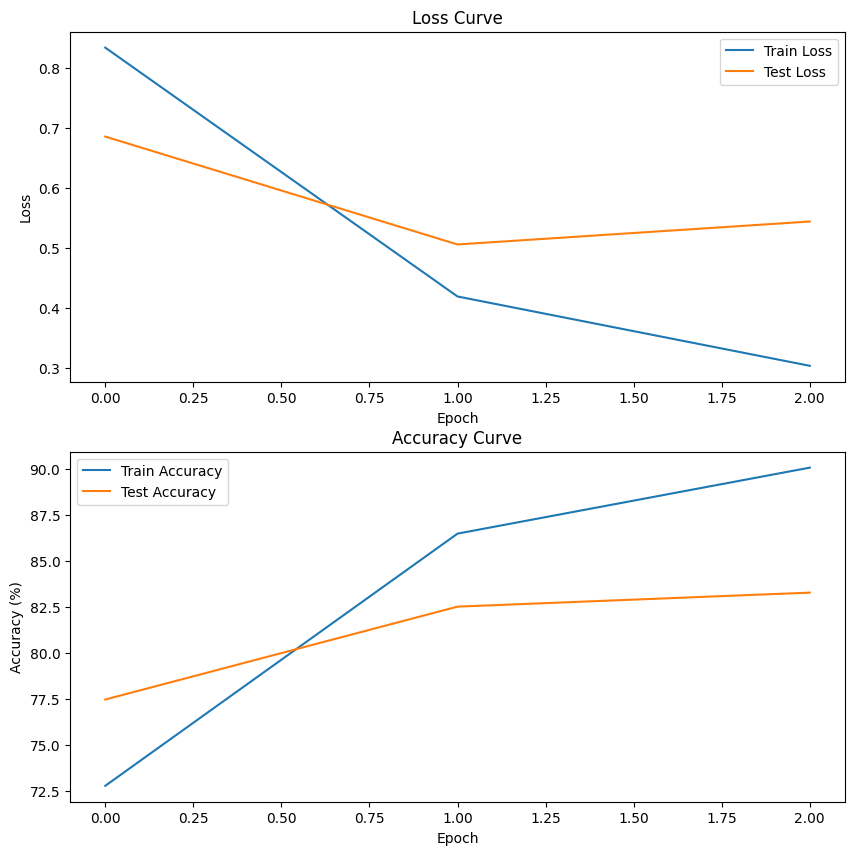

In [4]:
# Plot training results
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

# Loss curve
axs[0].plot(train_losses, label="Train Loss")
axs[0].plot(test_losses, label="Test Loss")
axs[0].set_title("Loss Curve")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss")
axs[0].legend()

# Accuracy curve
axs[1].plot(train_accuracies, label="Train Accuracy")
axs[1].plot(test_accuracies, label="Test Accuracy")
axs[1].set_title("Accuracy Curve")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Accuracy (%)")
axs[1].legend()

plt.show()

Fine-tuning step: Modifies classifier[1] instead of fc.